***Template Knowledge base LangGraph***
###Step 1:
Gathered around 5 PDF's nature communication, Science magazine pdf and nano letters
###Step 2:
Coverted them into embeddings and stored in vector database

###Step 3: Template KB
a. For template knowledge base, Created prompts to understand various templates and how the papers are structured

b. Use websearch if the answer given by the LLM is not satisfactory. Understand how the templates are in general web results.

c. Used Step 2 to store the terminology knowlegde base into vector Database

d. Achieved a,b,c via LangGraph. Refer to templateLearnerLangGraph.ipynb for more details.

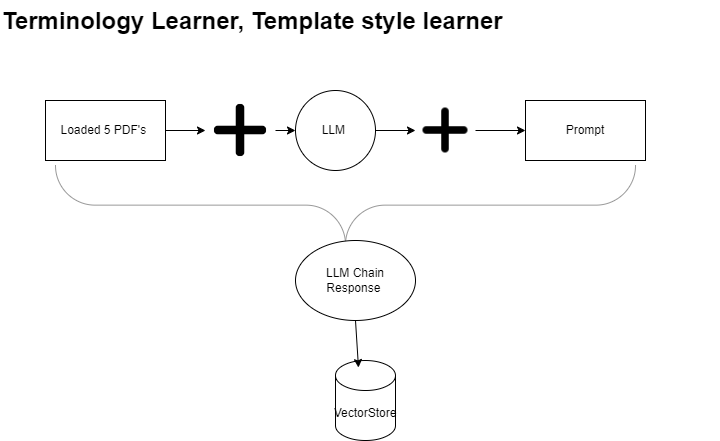




In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core  faiss-cpu  pypdf langchain_community mdutils datasets langchain_huggingface xmltodict sentence-transformers langchain_groq langchain_ollama langchain_mistralai fitz jq

In [2]:
import nest_asyncio
from typing import List, TypedDict, Any, Tuple
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from datetime import date, datetime
from langgraph.checkpoint.memory import MemorySaver

nest_asyncio.apply()

***Data Ingestion and Embedding***

In [13]:

from PIL import Image
import io
import os
from dotenv import load_dotenv

import google.generativeai as genai
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
#from langchain_cohere import ChatCohere, CohereEmbeddings
# Load environment variables from a .env file
from google.colab import userdata
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')

## Langsmith tracking
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get('TAVILY_API_KEY')


In [4]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
#Write a helper file
from langchain.document_loaders import TextLoader, CSVLoader, JSONLoader

#with open('/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/utility.py', 'r') as testwritefile:
#    print(testwritefile.read())
print("Hello utility!")
def load_files(file_paths):
    documents = []
    for file in file_paths:
        extension = get_file_type(file)
        print("Extension", extension)
        if extension == '.txt':
            loader = TextLoader(file)
        elif extension == '.csv':
            loader = CSVLoader(file)
        elif extension == '.json':
            loader = JSONLoader(file, jq_schema=".",json_lines=True,text_content=False)
        elif extension == '.pdf':
            loader = PyPDFLoader(file)
        else:
            continue
        documents.extend(loader.load())
    return documents

def get_file_type(file_path):
    _, extension = os.path.splitext(file_path)
    return extension.lower()



Hello utility!


In [6]:
%%writefile 'constants.py'
foldersjson={
    "terminologyDataset":"/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset",
    "trainingData":"/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/trainingData",
    "testData":"/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/testData",
}
MODEL_NAME=""

Writing constants.py


In [7]:
!cp utility.py '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/'
!cp constants.py '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/'

cp: cannot stat 'utility.py': No such file or directory


In [8]:
from constants import *
from utility import *
print(foldersjson)

Hello utility!
{'terminologyDataset': '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset', 'trainingData': '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/trainingData', 'testData': '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/testData'}


**Create terminology Knowledge Base**

In [9]:
import getpass
import os
allFileswithPath=[]
terminologyDataset=None

folders=foldersjson["terminologyDataset"]
for item in os.listdir(folders):
  filewithPath=folders+"/"+item
  print(filewithPath)
  allFileswithPath.append(filewithPath)


/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P5.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P3.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P6.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P2.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P1.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P4.pdf


In [11]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings


LangChain PyPDF loader mainly focusses on text data. I am using this loader as I need only textual data to understand the terminologies stated in the papers.

In [ ]:
#NO NEED TO RUN THIS CODE WHEN THE DATABASE IS ALREADY CREATED
'''documents=load_files(allFileswithPath)
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
final_documents=text_splitter.split_documents(documents)
embeddings=OpenAIEmbeddings()
vecStore=FAISS.from_documents(final_documents,embeddings)
indexName= "allPapers"
# Save the vector DB to your local
dbAllPapaers =vecStore.save_local(folder_path="/content/drive/MyDrive/Database", index_name=indexName)'''

Extension .pdf
Extension .pdf
Extension .pdf
Extension .pdf
Extension .pdf
Extension .pdf


<ipython-input-84-a0e1f690735b>:5: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings=OpenAIEmbeddings()


retrieve all the Paper data

In [15]:
from langchain.tools.retriever import create_retriever_tool
indexName= "allPapers"
dbAllPapaers=FAISS.load_local(folder_path="/content/drive/MyDrive/Database", index_name=indexName, embeddings=OpenAIEmbeddings(),allow_dangerous_deserialization=True)
allPapersRetreiever=dbAllPapaers.as_retriever()

***Terminology Knowledge base LangGraph***
1. Using the retriever as a tool
2. Creating a prompt
3. Adding a websearch as another chain
4. Store the results of all the terminologies used into the Vector Database


In [56]:
### Router
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )
# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

questionChainSystemPrompt = """You are an expert at routing a user question to a vectorstore or web search.
    The vectorstore contains documents related to science magazine and nature communications papers.
    Use the vectorstore for questions related to the context.
    Otherwise, use web-search. """

def getQuestionRouterllm(sysPrompt):
    # Prompt

    route_prompt = ChatPromptTemplate.from_messages(
      [
        ("system", sysPrompt),
        ("human", "{question}"),
      ]
    )
    question_router = route_prompt | structured_llm_router
    return question_router

In [57]:
def route_question(state):
    """
    Route question to web search or RAG.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = getQuestionRouterllm(questionChainSystemPrompt).invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


In [58]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [59]:
### Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
# Prompt
prompt = hub.pull("rlm/rag-prompt")
# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
# Chain
rag_chain = prompt | llm | StrOutputParser()

In [60]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

In [61]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with documents and generation with the generated answers
    """
    print("---WEB SEARCH---")
    question = state["question"]
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents = web_results
    print("Web Documents: "+str(documents))
    print("---GENERATE---")
    # Web generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents , "question": question,"generation": generation}

In [62]:
def generatevecDB(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = allPapersRetreiever.invoke(question)
    print("---GENERATE---")
    question = state["question"]
    state["documents"] =documents

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [63]:
def generatevecDB(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = allPapersRetreiever.invoke(question)
    print("---GENERATE---")
    question = state["question"]
    state["documents"] =documents
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}



In [64]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader
#TEST
#answer_grader.invoke({"question": question, "generation": generation})

In [65]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    print("---GRADE GENERATION vs QUESTION---")
    score = answer_grader.invoke({"question": question, "generation": generation})
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "useful"
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "not useful"

In [66]:
from langgraph.graph import END, StateGraph, START
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("vectorstore", generatevecDB)  # generatae

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "vectorstore",
    },
)
workflow.add_conditional_edges(
    "vectorstore",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "web_search",
    },
)
workflow.add_edge("web_search",END)
workflow.add_edge("vectorstore", END)

# Compile
app = workflow.compile()

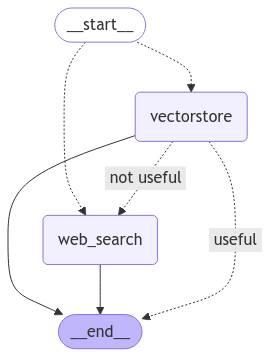

In [67]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Something happened")
    pass

In [73]:
from pprint import pprint
resultsQA={}
questionprompts={
    "generalScienceMagTemplate":"What is the generic template guidelines to create a science magazine report?",
    "ScienceMagazineTemplateinRAG": "How are the papers structured in the science magazine reports in the context?",
    "ScienceMagazineheadingsInRAG": "What are the various headings in the science magazine report in the context?",
    "generalNatureTemplate":"What is the generic template guidelines to create a Nature communications article?",
    "NatureArticleStructureinRAG": "How are the papers structured in the nature communications article in the context?",
    "NatureArticleHeadingsinRAG": "What are the various headings in the nature communications article in the context?",
    "p4paperStructure": "What is the structure of the 'Metamaterial Apertures for Computational Imaging' paper?",
    "tableOfcontentsSummaryofP4": "What is the summary of the table of contents of the 'Metamaterial Apertures for Computational Imaging' paper?",
}
# Run
answers = {}
for qkey, qq in questionprompts.items():
  inputs = {"question": qq}
  print("Question: "+ qq)
  for output in app.stream(inputs,{"recursion_limit": 100}):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        pprint("Value: "+str(value))
    pprint("\n---\n")
  print("Key:"+ str(key))
  resultsQA[qq] = value["generation"]
  # Final generation
  pprint("FINAL Answer: "+str(value["generation"]))
  #pprint(value["generation"])

Question: What is the generic template guidelines to create a science magazine report?
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---GENERATE---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
"Node 'vectorstore':"
("Value: {'question': 'What is the generic template guidelines to create a "
 'science magazine report?\', \'generation\': "I don\'t know.", \'documents\': '
 "[Document(metadata={'source': '/content/drive/MyDrive/Colab "
 "Notebooks/colab_data/ResearchPubAI/terminologyDataset/P4.pdf', 'page': 3}, "
 "page_content='ment, Tungasletta 2, NO-7047 Trondheim, Norway.\\n†These "
 'authors contributed equally to this work.\\n‡To whom correspondence should '
 'be addressed. E-mail:\\nbrage.b.hansen@ntnu.no\\nwww.sciencemag.org SCIENCE '
 'VOL 339 18 JANUARY 2013 313\\nREPORTS\\nDownloaded from '
 "https://www.science.org at Rice University on November 09, 2024'), "
 "Document(metadata={'source': '/content/drive/MyDrive/Col

In [74]:
resultsQA

{'What is the generic template guidelines to create a science magazine report?': 'The generic template guidelines to create a science magazine report typically follow the IMRAD format: Introduction, Methods, Results, And Discussion. The Introduction should state the hypothesis, the Methods section details how the hypothesis was tested, the Results section provides raw data, and the Discussion section interprets the data and explores implications. Statistical guidelines should include details on the statistical test used, n values, comparisons of interest, alpha levels, and P values for each test.',
 'How are the papers structured in the science magazine reports in the context?': 'The papers in the science magazine reports are structured with sections such as "REPORTS" and "RESEARCH." Each paper includes information about the authors, their affiliations, and contact details. The papers also provide a link for downloading the full text.',
 'What are the various headings in the science ma

In [76]:
import json
with open('templateKnowledgeBase.json', 'w') as f:
    json.dump(resultsQA, f)
!cp templateKnowledgeBase.json '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/'

In [79]:
#NO NEED TO RUN THIS CODE WHEN THE DATABASE IS ALREADY CREATED
allPaths=["templateKnowledgeBase.json"]
documents=load_files(allPaths)
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
final_documents=text_splitter.split_documents(documents)
embeddings=OpenAIEmbeddings()
vecStore=FAISS.from_documents(final_documents,embeddings)
indexName= "templateKnowledgeBase"
# Save the vector DB to your local
dbAllPapaers =vecStore.save_local(folder_path="/content/drive/MyDrive/Database", index_name=indexName)

Extension .json
